In [1]:
%matplotlib inline
import pennylane as qml
import torch
import torch.autograd as autograd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from IPython import display
import math
import itertools

torch.manual_seed(42)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
torch.set_default_device(device)

## QCircuit parameter
n_wires = 6
n_layers = 3

## Optimizer Settings
boundary_loss_scaling = 1

# Domain Settings
n_t_steps = 50
t_prop = (0,0.2,n_t_steps)
n_x_steps = 50
x_prop = (-1,1,n_x_steps)

# Boundary values
#        bd1
#       |---|
#  bd4  |   | bd2 (not used)
#       |---|
#        bd3
def bd1_fnc(input_values, function_values):
    return 0 - function_values

def bd3_fnc(input_values, function_values):
    return 0 - function_values

def bd4_fnc(input_values, function_values):
    return function_values - (-torch.sin(torch.pi*input_values[:,1]))

t = torch.linspace(t_prop[0],t_prop[1],t_prop[2], requires_grad=True, device=device)
x = torch.linspace(x_prop[0],x_prop[1],x_prop[2], requires_grad=True, device=device)
input_values = torch.tensor([x for x in itertools.product(t, x)], requires_grad=True)


@qml.qnode(qml.device("default.qubit.torch", wires=n_wires), interface='torch', diff_method="best", max_diff=3)
def circuit(input_values, weights):
    # Embedding
    for i in range(n_wires):
        if i%2 == 0:
            qml.RY(2*i*torch.tanh(input_values[1]),wires = i)
        else:
            qml.RY(2*i*torch.tanh(input_values[0]),wires = i)
    #Variational ansatz
    qml.BasicEntanglerLayers(weights=weights, wires=range(n_wires))
    # Cost function
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))

def my_model(input_values, weights, bias, scaling):
    vcircuit = torch.vmap(circuit, in_dims=(0,None))
    return scaling[0]*vcircuit(input_values, weights[0]) + bias[0]


def differential_loss_fnc(input_values, weights, biases, scaling):
    u_pred = my_model(input_values, weights, biases, scaling)
    
    
    grad_outputs_1 = torch.ones_like(u_pred)
    du = autograd.grad(u_pred, input_values, grad_outputs=grad_outputs_1, create_graph=True)[0]
    du_dt_pred = du[:,0]
    du_dx_pred = du[:,1]
    
    du_du_dx = autograd.grad(du_dx_pred, input_values, grad_outputs=grad_outputs_1, create_graph=True)[0]
    du_dx_dx_pred = du_du_dx[:,1]
    
    res_pde = du_dt_pred  + u_pred * du_dx_pred - 0.01/torch.pi*du_dx_dx_pred
    #res_pde = du_dt_pred + u_pred*du_dx_pred - 0.01/torch.pi*du_dx_dx_pred

    return torch.mean(res_pde**2)

def boundary_loss_fnc(input_values, weights, biases, scaling):

    bd1_input_values = torch.vstack((t,torch.ones_like(x))).T
    bd1_loss_val = bd1_fnc(bd1_input_values, my_model(bd1_input_values, weights, biases, scaling))

    bd3_input_values = torch.vstack((t,-torch.ones_like(x))).T
    bd3_loss_val = bd3_fnc(bd3_input_values, my_model(bd3_input_values, weights, biases, scaling))

    bd4_input_values = torch.vstack((torch.zeros_like(t),x)).T
    bd4_loss_val = bd4_fnc(bd4_input_values, my_model(bd4_input_values, weights, biases, scaling))

    return boundary_loss_scaling * (torch.mean(bd1_loss_val**2) + torch.mean(bd3_loss_val**2) + torch.mean(bd4_loss_val**2))
    
def loss_fnc(input, weights, biases, scaling):
    return boundary_loss_fnc(input, weights, biases, scaling) + differential_loss_fnc(input, weights, biases, scaling)

def closure():
    global lbfgs
    lbfgs.zero_grad()
    loss = loss_fnc(input_values,weights, biases, scaling)
    loss.backward()
    return loss


def optimize(n_iter = 100, verbose=0, optimizer="adam"):

    def update(verbose):
        if verbose == 1:
            print(f"Step: {i}  Loss: {loss}")
        elif verbose == 2:
            fig = plt.figure()
            fig.set_figheight(5)
            fig.set_figwidth(20)
            #plt.suptitle(r"\frac{-e^{i\pi}}{2^n}$!", fontsize=18)

            # Add energy plot on column 1
            ax1 = fig.add_subplot(121)
            ax1.grid()
            ax1.plot(range(len(loss_history)), loss_history, "black", ls="solid", lw=4, alpha=0.6)
            ax1.plot(range(len(loss_diff_history)), loss_diff_history, "g", ls="dotted",lw=2)
            ax1.plot(range(len(loss_boundary_history)), loss_boundary_history, "r", ls="dashed",lw=2)
            ax1.plot(range(len(loss_analytical_history)), loss_analytical_history, "b", ls="dashdot",lw=2)
            ax1.legend(["total loss", "diff loss", "boundary loss", "analytical loss"], fontsize=9, loc=1)
            ax1.set_yscale('log')
            ax1.set_xlabel("Optimization step", fontsize=13)
            ax1.set_ylabel("Loss", fontsize=13)
            ax1.set_title("Loss",fontsize=16)

            ax2 = fig.add_subplot(122)
            ax2.grid()
            u = my_model(input_values, weights, biases, scaling).to("cpu")
            u = u.reshape(len(x), len(t)).detach().numpy()
            contourf = ax2.contourf(x.to("cpu").detach(), t.to("cpu").detach(), u, levels=50, cmap="jet")
            ax2.set_xlabel("x", fontsize=13)
            ax2.set_ylabel("t", fontsize=13)
            ax2.set_title("Function Values",fontsize=16)
            cbar = fig.colorbar(contourf, ax=ax2, )
            cbar.set_label('u', fontsize=13)  # Set label for the colorbar
            
            display.clear_output(wait=True)
            plt.show()
            print(f"Step: {i}  Loss: {loss}")
    
    for i in range(1,n_iter+1):
        if optimizer == "adam":
            opt.zero_grad()
            loss = loss_fnc(input_values,weights, biases, scaling)
            loss.backward()
            opt.step()
        if optimizer == "lbfgs":
            lbfgs.step(closure)
            loss = loss_fnc(input_values,weights, biases, scaling)

        loss_history.append(loss.to("cpu").detach())
        loss_diff_history.append(differential_loss_fnc(input_values, weights, biases, scaling).to("cpu").detach())
        loss_boundary_history.append(boundary_loss_fnc(input_values, weights, biases, scaling).to("cpu").detach())

        if optimizer == "adam":
            if i%10 == 0 : update(verbose)
        if optimizer == "lbfgs":
            if i%1 == 0 : update(verbose)
        
weights = [torch.rand((n_layers, n_wires), requires_grad=True, device=device)]        
biases = [torch.rand(1, requires_grad=True, device=device)]
scaling = [torch.rand(1, requires_grad=True, device=device)]

parameters = weights + biases + scaling

# Create optimizer
lbfgs = torch.optim.LBFGS(parameters, line_search_fn="strong_wolfe")

opt = torch.optim.Adam(parameters, lr=0.1)
loss_history = []
loss_diff_history = []
loss_boundary_history = []
loss_analytical_history = []

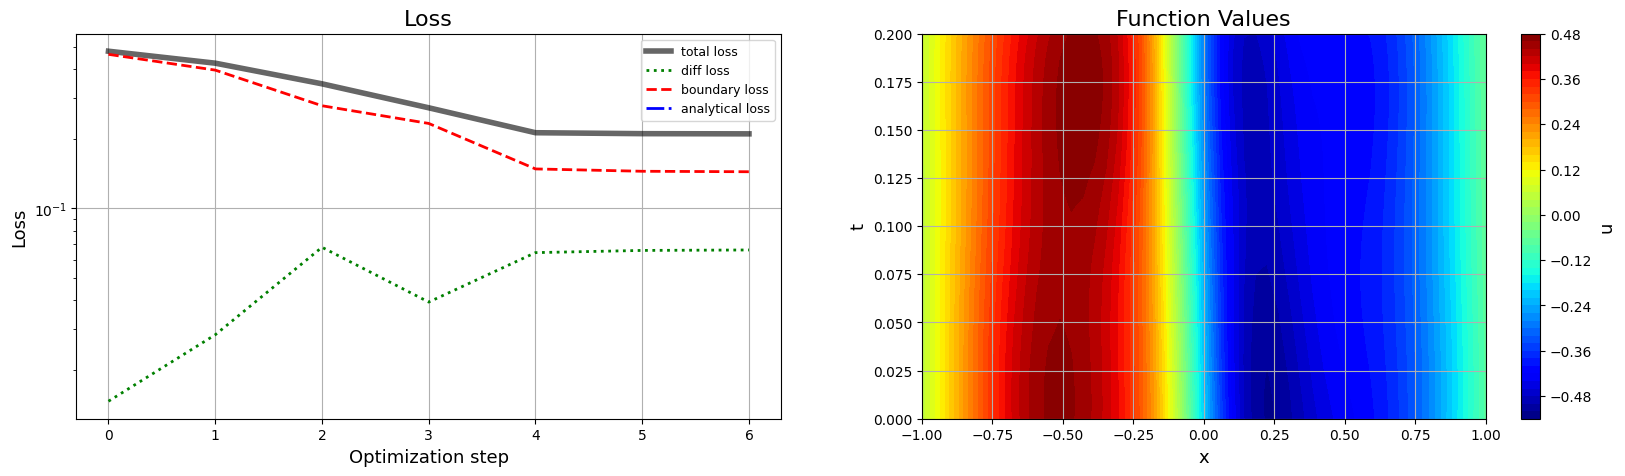

Step: 7  Loss: 0.20987025869987974


In [2]:
opt.param_groups[0]["lr"] = 0.01
%timeit -r1 -n1 optimize(n_iter=2000, verbose=2, optimizer="lbfgs")